### Importing Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

# set all seed
def set_seed(seed=42):
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # if torch.cuda.is_available():
    #     torch.cuda.manual_seed_all(seed)

seed = 0
set_seed(seed)

### Defining Important Functions

In [3]:

def plot_data(df, x_col, y_col, title, xlabel, ylabel, figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.plot(df[x_col], df[y_col])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

def calculate_nse(observed, predicted):
    """Calculate Nash-Sutcliffe Efficiency (NSE)"""
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - np.mean(observed)) ** 2)
    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):
    """Calculate Root Mean Square Error (RMSE)"""
    rmse = np.sqrt(np.mean((observed - predicted) ** 2))
    return rmse


def calculate_mae(observed, predicted):
    """Calculate Mean Absolute Error (MAE)"""
    mae = np.mean(np.abs(observed - predicted))
    return mae

def calculate_physical_consistency(observed, predicted):
    """Check if predicted values are realistic (e.g., non-negative)"""
    consistency = np.all(predicted >= 0)
    return consistency

# Calculate performance metrics
def calc_metrics(observed, predicted):
    rmse = calculate_rmse(observed, predicted)
    mae = calculate_mae(observed, predicted)
    nse = calculate_nse(observed, predicted)
    physical_consistency = calculate_physical_consistency(observed, predicted)
    print(f"RMSE = {rmse:.2f}, MAE = {mae:.2f}, NSE = {nse:.2f}, Physical Consistency = {physical_consistency}")
    return rmse, mae, nse, physical_consistency


def plot_ground_truth_vs_prediction(df, y_pred, title_hourly, title_daily, ylabel, figsize=(15, 5)):
    """Plot ground truth vs predictions for hourly and daily data."""
    # Plot hourly predictions
    plt.figure(figsize=figsize)
    plt.plot(df['valid_time'], df['tp'], label='Ground Truth', color='blue')
    plt.plot(df['valid_time'], y_pred[:, 0], label='Predicted Hourly', color='orange')
    plt.title(title_hourly)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

    # Plot daily predictions
    daily_pred_df = pd.merge(df[['valid_time']], pd.DataFrame(y_pred, columns=target), left_index=True, right_index=True)
    daily_pred_df = daily_pred_df[daily_pred_df['valid_time'].dt.hour == 0]
    plt.figure(figsize=figsize)
    plt.plot(df[df['valid_time'].dt.hour == 0]['valid_time'], df[df['valid_time'].dt.hour == 0]['tp'], label='Ground Truth', color='blue')
    plt.plot(daily_pred_df['valid_time'], daily_pred_df['tp'], label='Predicted Daily', color='orange')
    plt.title(title_daily)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()


### Loading Data

In [4]:
def add_cycle_features(df):
    """Add cyclic features for month and year to the dataframe."""
    df['valid_time'] = pd.to_datetime(df['valid_time'])
    df['month_sin'] = np.sin(2 * np.pi * df['valid_time'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['valid_time'].dt.month / 12)
    df['year_sin'] = np.sin(2 * np.pi * df['valid_time'].dt.year / 12)
    df['year_cos'] = np.cos(2 * np.pi * df['valid_time'].dt.year / 12)
    return df

In [5]:
data_dir = './data/'

train_df = pd.read_csv(os.path.join(data_dir, 'train_data.csv'))
train_df = add_cycle_features(train_df)
train_df.drop(columns=['second', 'minute'], inplace=True)
train_df['valid_time'] = pd.to_datetime(train_df['valid_time'])
print("Shape of training data:", train_df.shape)

val_df = pd.read_csv(os.path.join(data_dir, 'val_data.csv'))
val_df = add_cycle_features(val_df)
val_df.drop(columns=['second', 'minute'], inplace=True)
val_df['valid_time'] = pd.to_datetime(val_df['valid_time'])
print("Shape of validation data:", val_df.shape)

test_df = pd.read_csv(os.path.join(data_dir, 'test_data.csv'))
test_df = add_cycle_features(test_df)
test_df.drop(columns=['second', 'minute'], inplace=True)
test_df['valid_time'] = pd.to_datetime(test_df['valid_time'])
print("Shape of test data:", test_df.shape)

Shape of training data: (87672, 25)
Shape of validation data: (17520, 25)
Shape of test data: (17544, 25)


In [6]:
display(train_df.head())


,valid_time,tp,year,month,day,hour,yearly_mean,yearly_max,yearly_min,yearly_std,...,monthly_var,daily_mean,daily_max,daily_min,daily_std,daily_var,month_sin,month_cos,year_sin,year_cos
0,2011-01-01 00:00:00,0.000166,2011,1,1,0,0.00028,0.003323,0.0,0.000407,...,9.706095e-10,0.000069,0.000166,0.000026,0.000042,1.801785e-09,0.5,0.866025,-0.5,-0.866025
1,2011-01-01 01:00:00,0.000103,2011,1,1,1,0.00028,0.003323,0.0,0.000407,...,9.706095e-10,0.000069,0.000166,0.000026,0.000042,1.801785e-09,0.5,0.866025,-0.5,-0.866025
2,2011-01-01 02:00:00,0.000083,2011,1,1,2,0.00028,0.003323,0.0,0.000407,...,9.706095e-10,0.000069,0.000166,0.000026,0.000042,1.801785e-09,0.5,0.866025,-0.5,-0.866025
3,2011-01-01 03:00:00,0.000078,2011,1,1,3,0.00028,0.003323,0.0,0.000407,...,9.706095e-10,0.000069,0.000166,0.000026,0.000042,1.801785e-09,0.5,0.866025,-0.5,-0.866025
4,2011-01-01 04:00:00,0.000095,2011,1,1,4,0.00028,0.003323,0.0,0.000407,...,9.706095e-10,0.000069,0.000166,0.000026,0.000042,1.801785e-09,0.5,0.866025,-0.5,-0.866025


In [7]:
features = ['year', 'month', 'day', 'hour',
            'yearly_mean', 'yearly_max', 'yearly_min', 'yearly_std',
            'monthly_mean', 'monthly_max', 'monthly_min', 'monthly_std',
            'month_sin', 'month_cos', 'year_sin', 'year_cos']
target = ['tp']

for i in ['yearly_mean', 'yearly_max', 'yearly_min', 'yearly_std', 
          'monthly_mean', 'monthly_max', 'monthly_min', 'monthly_std', 'tp']:
    train_df[i] = train_df[i] * 1000
    val_df[i] = val_df[i] * 1000
    test_df[i] = test_df[i] * 1000

In [8]:
daily_train_df = train_df.resample('D', on='valid_time').mean().reset_index()
daily_train_df['valid_time'] = pd.to_datetime(daily_train_df['valid_time'])

daily_val_df = val_df.resample('D', on='valid_time').mean().reset_index()
daily_val_df['valid_time'] = pd.to_datetime(daily_val_df['valid_time'])

daily_test_df = test_df.resample('D', on='valid_time').mean().reset_index()
daily_test_df['valid_time'] = pd.to_datetime(daily_test_df['valid_time'])


## Training

In [13]:
model = ARIMA(daily_train_df['tp'], order=(5, 1, 2))
model_fit = model.fit()


c:\Users\shard\Desktop\Hackrush 2025\Temporal-Downscaling\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\shard\Desktop\Hackrush 2025\Temporal-Downscaling\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\shard\Desktop\Hackrush 2025\Temporal-Downscaling\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE = 0.41, MAE = 0.24, NSE = -0.20, Physical Consistency = True


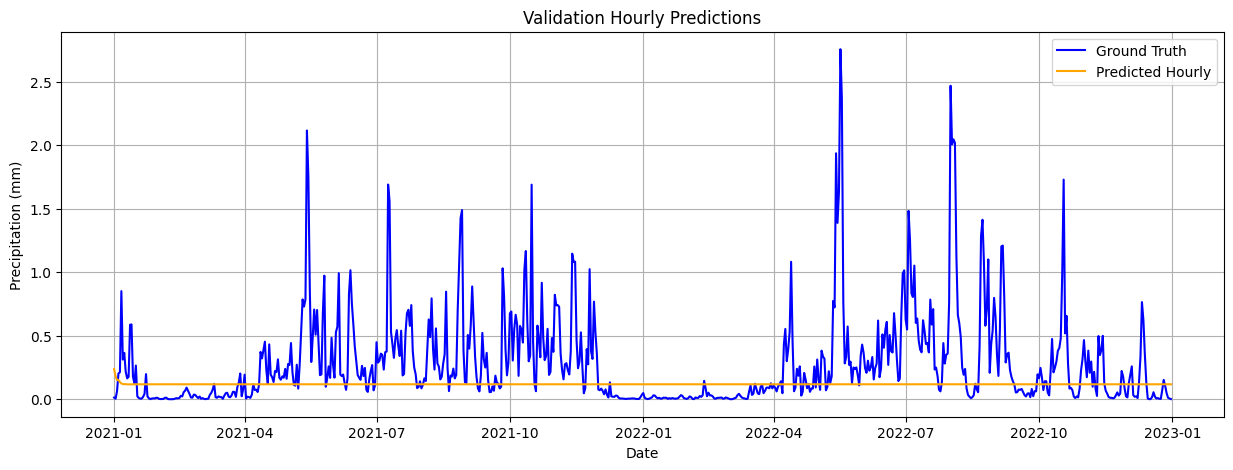

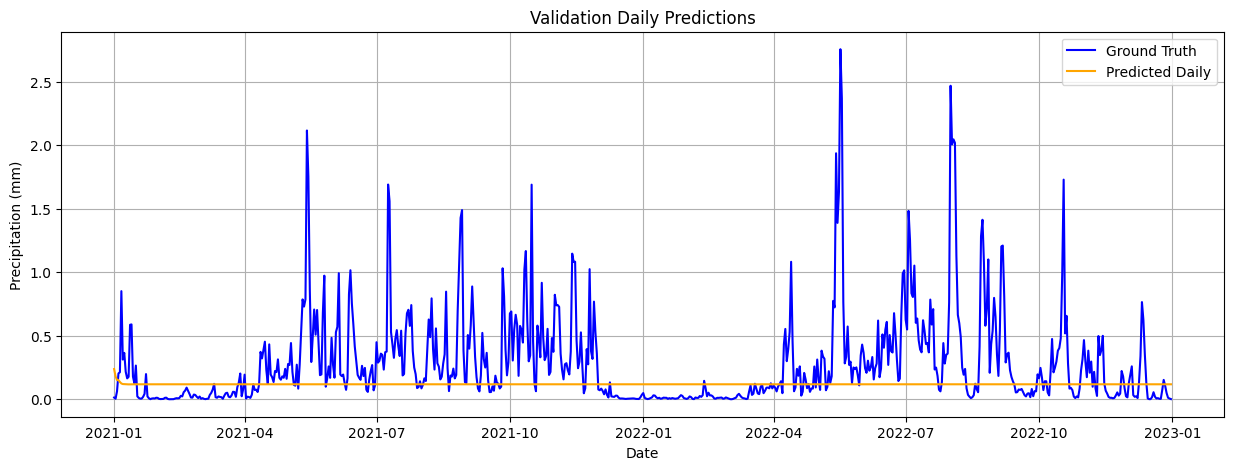

In [14]:
y_pred = model_fit.forecast(steps=len(daily_val_df))

y_pred = np.array(y_pred).reshape(-1, 1)
# Calculate performance metrics
calc_metrics(daily_val_df['tp'].values, y_pred[:, 0])
# Plot ground truth vs predictions
plot_ground_truth_vs_prediction(daily_val_df, y_pred,
                                  title_hourly='Validation Hourly Predictions', 
                                  title_daily='Validation Daily Predictions',
                                  ylabel='Precipitation (mm)')
# Save the model
model_fit.save(os.path.join(data_dir, 'arima_model.pkl'))
